In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import ode

In [2]:
def V_eff(r, L, kappa):
    """kappa = 0 gives null trajectories, kappa = 1 timelike"""
    return 0.5 * (1 - 2/r) * (kappa + L**2/r**2)

def V_eff_deriv(r, L, kappa):
    return (kappa * r**2 - L**2 * (r - 3))/r**4


In [3]:
def r_orbit(L, sign):
    return L**2 / 2 * (1 + sign * np.sqrt(1 - 12/L**2))

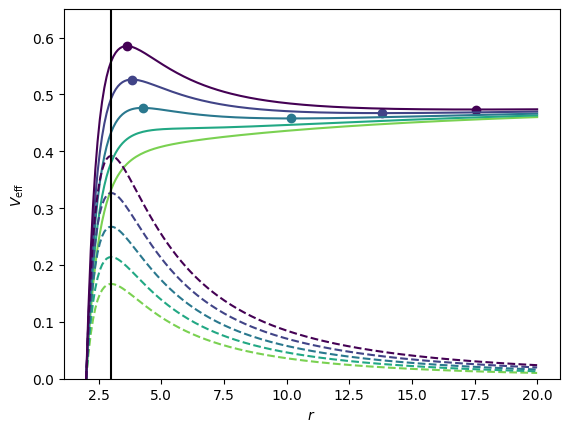

In [4]:
r_space = np.linspace(2, 20, 200)
L_list = np.linspace(3, 4.6, 5)

for i, L in enumerate(L_list):
    color = cm.viridis_r((i + 1)/len(L_list))
    plt.plot(r_space, V_eff(r_space, L, 0), ls='dashed', color=color)
    plt.plot(r_space, V_eff(r_space, L, 1), color=color)
    if L >= np.sqrt(12):
        r_unstable = r_orbit(L, -1)
        r_stable = r_orbit(L, +1)
        plt.scatter(r_stable, V_eff(r_stable, L, 1), color=color)
        plt.scatter(r_unstable, V_eff(r_unstable, L, 1), color=color)
plt.axvline(3, color='black')
plt.ylim(0, 0.65)
plt.ylabel(r'$V_\text{eff}$')
plt.xlabel(r'$r$');

In [5]:
def t_dot(r, E):
    return E/(1 - 2/r)

def phi_dot(r, L):
    return L / r**2

def r_dot(r, E, L, kappa, sign):
    return sign * (E**2 - 2*V_eff(r, L, kappa))**0.5  ## sqrt not square!

def r_ddot(r, L, kappa):
    return -V_eff_deriv(r, L, kappa)

We define $v=\dot{r}$ to formulate second-order ODEs as a set of first-order ODEs and collect all four variables in list $x=[t, r, \phi, v]$ so $\dot{x} = [\dot{t}, v, \dot{\phi}, \ddot{r}]$.

In [6]:
def integrate_geodesic(r0, phi0, E, L, kappa, sign, step, intensity_profile=None):
    tau_history = [ 0. ]
    x_history = [ [0, r0, phi0, r_dot(r0, E, L, kappa, sign)] ]

    def x_dot(tau, x):      ## define here, or outside and include E, L, etc. as arguments
        t, r, phi, v = x
        return [
            t_dot(r, E),
            v,
            phi_dot(r, L),
            r_ddot(r, L, kappa),
        ]

    integrator = ode(x_dot).set_integrator('zvode', method='bdf').set_initial_value(x_history[0], tau_history[0])

    if intensity_profile is not None:
        intensity = 0.

    while integrator.successful():
        current_x = integrator.integrate(integrator.t + step)
        x_history.append(current_x)
        tau_history.append(integrator.t)

        if intensity_profile is not None:
            intensity += step * intensity_profile(*current_x)

        t, r, phi, v = current_x
        if phi > 5 * 2 * np.pi:
            break
        if r < 0:
            break
        if r > 3 * r0:
            break

    tau_history, x_history = np.real(np.asarray(tau_history)), np.real(np.asarray(x_history))
    if intensity_profile is not None:
        return tau_history, x_history, intensity
    else:
        return tau_history, x_history

(0.46, 0.49)

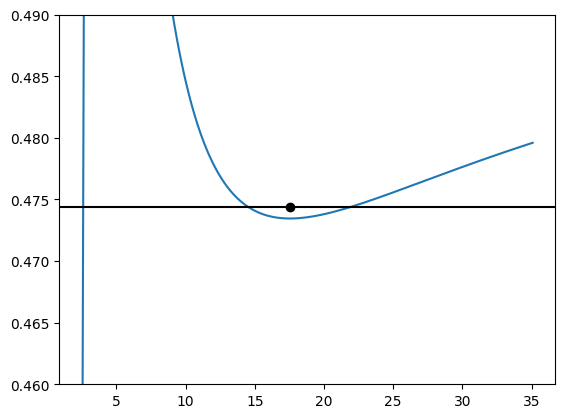

In [11]:
# Choose some angular momentum L > L_min
L = 4.6
# Choose to start at the circular orbit radius
r0 = r_orbit(L, sign=1)
# Choose an energy slightly larger than the circular orbit so we obtain an elliptic orbit
E = np.sqrt(2 * V_eff(r0, L, 1)) * (1 + 1e-3)

r_space = np.linspace(2.5, 2 * r0, 200)
plt.figure()
plt.plot(r_space, V_eff(r_space, L, 1))
plt.axhline(E**2 / 2, color='black')
plt.scatter(r0, E**2 / 2, color='black')
plt.ylim(.46, .49)

In [12]:
tau, x = integrate_geodesic(r0=r0, phi0=0, E=E, L=L, kappa=1, sign=-1, step=0.5)

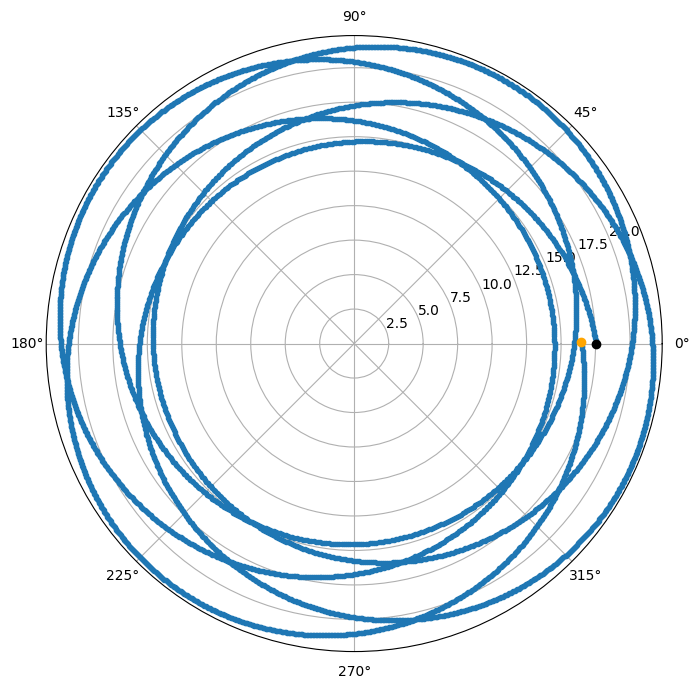

In [13]:
plt.figure(figsize=(8, 8))
plt.polar(x[:,2], x[:,1], marker='.', ls='dotted')
plt.polar(x[0,2], x[0,1], marker='o', color='black')
plt.polar(x[-1,2], x[-1,1], marker='o', color='orange');

For a particular energy the orbit closes after $N$ turns:

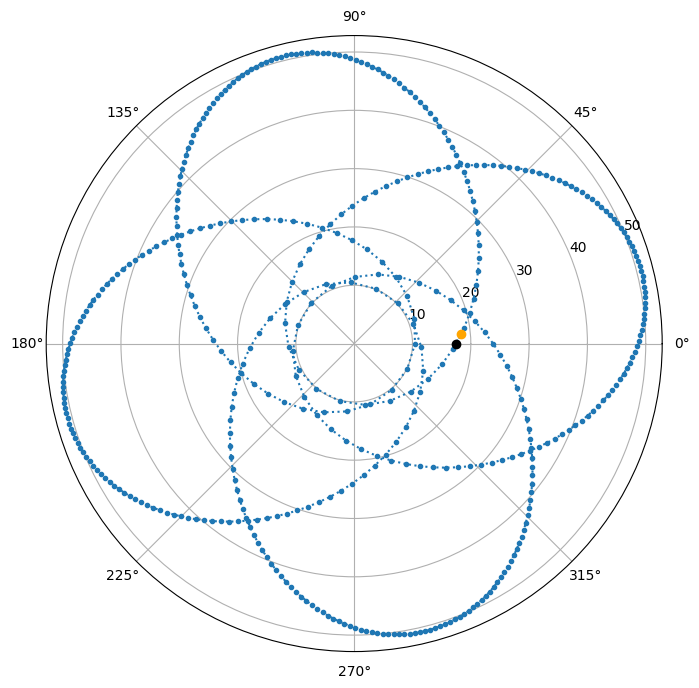

In [14]:
L = 4.6
r0 = r_orbit(L, 1)
E = np.sqrt(2 * V_eff(r0, L, 1) * 1.0228)

plt.figure(figsize=(8, 8))
tau, x = integrate_geodesic(r0, 0, E, L, 1, 1, 10)
plt.polar(x[:,2], x[:,1], marker='.', ls='dotted')
plt.polar(x[0,2], x[0,1], marker='o', color='black')
plt.polar(x[-1,2], x[-1,1], marker='o', color='orange')

# Light Rays

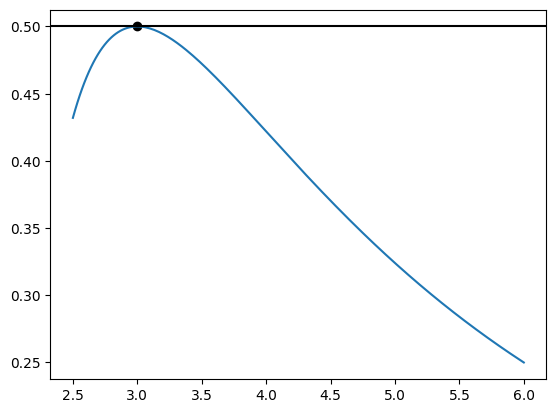

In [16]:
r0 = 3
E = 1
L = np.sqrt(27)

r_space = np.linspace(2.5, 2*r0, 200)

plt.figure()
plt.plot(r_space, V_eff(r_space, L, kappa=0))
plt.axhline(E**2/2, color='k')
plt.scatter(r0, E**2/2, color='k')



In [17]:
tau, x = integrate_geodesic(r0=r0, phi0=0, E=E, L=L, kappa=0, sign=-1, step=0.5)

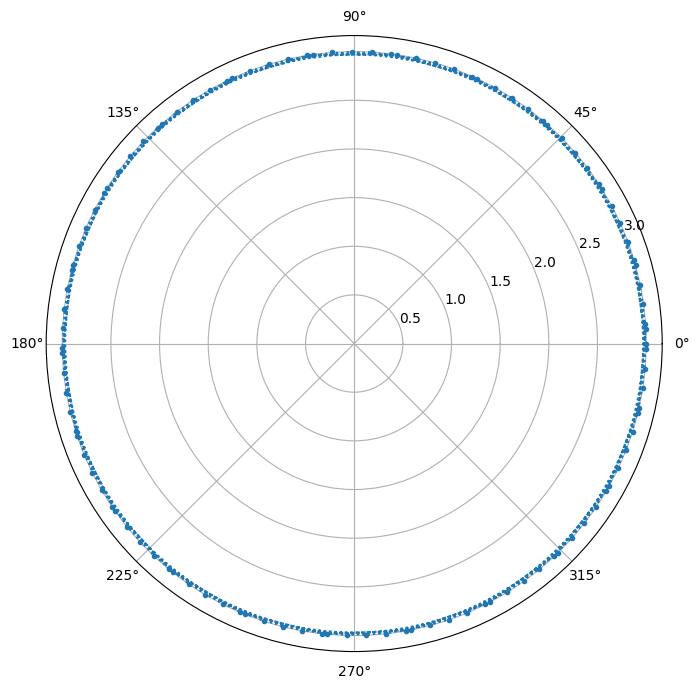

In [18]:
plt.figure(figsize=(8, 8))
plt.polar(x[:, 2], x[:, 1], marker='.', ls='dotted');

In [19]:
def jacobian_cart_to_polar(r, phi):
    return np.array([[np.cos(phi), np.sin(phi)], [-np.sin(phi)/r, np.cos(phi)/r]])

def cart_to_polar(x, y):
    return np.sqrt(x**2 + y**2), np.arctan2(y, x)

In [20]:
def intensity_profile(t, r, phi, *args):
    return 1 / r**2

 ZVODE--  Warning: internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.8000000000000D+01   R2 =  0.4057613155650D-15
 ZVODE--  Warning: internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.8000000000000D+01   R2 =  0.4057613155650D-15
 ZVODE--  Above warning has been issued I1 times.  
       it will not be issued again for this problem
      In above message,  I1 =         2
 ZVODE--  Warning: internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver will continue anyway
      In above,  R1 =  0.8005750355340D+01   R2 =  0.1451752666383D-15
 ZVODE--  Warning: internal T (=R1) and H (=R2) are
       such that in the machine, T + H = T on the next step  
       (H = step size). solver 

/Users/bfarr/miniconda3/envs/phys-483-583/lib/python3.11/site-packages/scipy/integrate/_ode.py:438: UserWarning: zvode: Excess work done on this call. (Perhaps wrong MF.)
  self._y, self.t = mth(self.f, self.jac or (lambda: None),
/var/folders/b2/qcvsw_h948b_826rl483srp40000gn/T/ipykernel_7208/663307542.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  tau, x, intensities[i] = integrate_geodesic(r_0, phi_0, E, L, kappa=0, sign=-1, step=0.1, intensity_profile=intensity_profile)


(0.0, 10.0)

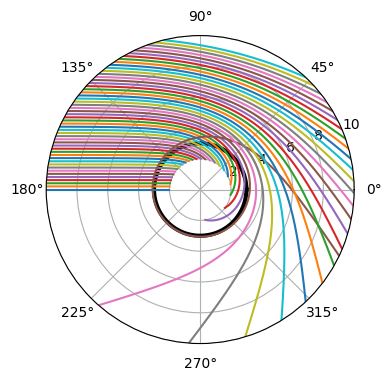

In [25]:
plt.figure(figsize=(4, 4))
phi_space = np.linspace(0, 2*np.pi, 100)
plt.polar(phi_space, 3 * np.ones(len(phi_space)), color='black', lw=3)

x_0 = -10
y_space = np.linspace(0, 10, 50)
k_0 = np.array([1, 0])

intensities = np.zeros(len(y_space))

for i, y_0 in enumerate(y_space):
    r_0, phi_0 = cart_to_polar(x_0, y_0)
    k_r_0, k_phi_0 = jacobian_cart_to_polar(r_0, phi_0) @ k_0

    L = r_0**2 * k_phi_0
    E = np.sqrt(k_r_0**2 + 2 * V_eff(r_0, L, 0))

    tau, x, intensities[i] = integrate_geodesic(r_0, phi_0, E, L, kappa=0, sign=-1, step=0.1, intensity_profile=intensity_profile)
    plt.polar(x[:, 2], x[:, 1], marker='', ls='-')
plt.ylim(0, np.abs(np.max(y_space)))
